In [1]:
import quimb as qu
import quimb.tensor as qtn
import random
import math
import pybobyqa
import numpy as np
import tqdm
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective

In [2]:
#Qubits on Square-Octagon Lattice w/ Lattice Parameters
qubits = [0, 1, 2, 3, 4, 5, 6, 7]
Nq = len(qubits)

xx_links = [(0, 1), (2, 3)]
yy_links = [(0, 3), (1, 2)]
yy_links_reversed = [(1, 2), (0, 3)]
zz_links = [(0, 4), (1, 5), (2, 6), (3, 7)]
zz_links_reversed = [(3, 7), (2, 6), (1, 5), (0, 4)]

Jx, Jy, Jz = -1.0/math.sqrt(2), -1.0/math.sqrt(2), -1.0
hX = hY = hZ = 0.05/math.sqrt(3)

In [3]:
#Hamiltonian Construction
H_dims = [2] * Nq
H = 0
for (i,j) in xx_links:
    H += Jx*qu.pkron(qu.pauli('X') & qu.pauli('X'), H_dims, inds=[i, j])
for (i,j) in yy_links:
    H += Jy*qu.pkron(qu.pauli('Y') & qu.pauli('Y'), H_dims, inds=[i, j])
for (i,j) in zz_links:
    H += Jz*qu.pkron(qu.pauli('Z') & qu.pauli('Z'), H_dims, inds=[i, j])
for q in qubits:
    H += hX*qu.ikron(qu.pauli('X'), H_dims, q) + hY*qu.ikron(qu.pauli('Y'), H_dims, q) + hZ*qu.ikron(qu.pauli('Z'), H_dims, q)

In [4]:
##Hamiltonian Variational Ansatz Circuit Tensor Network Construction
def HVA_circuit(alpha, beta, gamma, alpha_mag, beta_mag, gamma_mag, n_layers):
    global xx_links
    global yy_links
    global yy_links_reversed
    global zz_links
    global zz_links_reversed
    global qubits
    #Initialize Circuit
    HVA = qtn.Circuit(Nq)
    #Ansatz Construction
    for idx_layer in range(n_layers):
    #Construct X-terms portion of layer
        for q in range(Nq):
            HVA.apply_gate('RX', 2*alpha_mag[idx_layer], q, gate_round=idx_layer)
        for (i,j) in xx_links:
            HVA.apply_gate('H', i, gate_round=idx_layer)
            HVA.apply_gate('H', j, gate_round=idx_layer)
            HVA.apply_gate('CNOT', max(i,j), min(i,j), gate_round=idx_layer)
            HVA.apply_gate('RZ', 2*alpha[idx_layer], min(i,j), gate_round=idx_layer)
            HVA.apply_gate('CNOT', max(i,j), min(i,j), gate_round=idx_layer)
            HVA.apply_gate('H', i, gate_round=idx_layer)
            HVA.apply_gate('H', j, gate_round=idx_layer)
    #Construct Y-terms portion of layer
        for q in range(Nq):
            HVA.apply_gate('RY', 2*beta_mag[idx_layer], q, gate_round=idx_layer)
        for (i,j) in yy_links:
            HVA.apply_gate('RX', math.pi/2, i, gate_round=idx_layer)
            HVA.apply_gate('RX', math.pi/2, j, gate_round=idx_layer)
            HVA.apply_gate('CNOT', max(i,j), min(i,j), gate_round=idx_layer)
        for (i,j) in yy_links_reversed:
            HVA.apply_gate('RZ', 2*beta[idx_layer], min(i,j), gate_round=idx_layer)
            HVA.apply_gate('CNOT', max(i,j), min(i,j), gate_round=idx_layer)
            HVA.apply_gate('RX', -math.pi/2, i, gate_round=idx_layer)
            HVA.apply_gate('RX', -math.pi/2, j, gate_round=idx_layer)
    #Construct Z-terms portion of layer
        for q in range(Nq):
            HVA.apply_gate('RZ', 2*gamma_mag[idx_layer], q, gate_round=idx_layer)
        for (i,j) in zz_links:
            HVA.apply_gate('CNOT', max(i,j), min(i,j), gate_round=idx_layer)
        for (i,j) in zz_links_reversed:
            HVA.apply_gate('RZ', 2*gamma[idx_layer], min(i,j), gate_round=idx_layer)
            HVA.apply_gate('CNOT', max(i,j), min(i,j), gate_round=idx_layer)
    return HVA

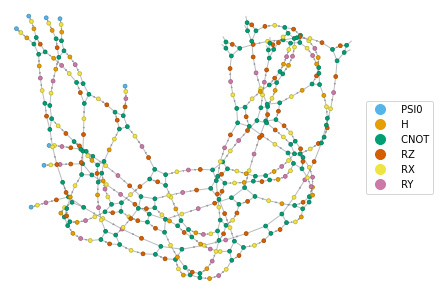

In [7]:
#Circuit Tensor Network Picture
#par = np.random.uniform(-np.pi, np.pi, size=6*5)
#alpha = params[:5]
#beta = params[5:2*5]
#gamma = params[2*5:3*5]
#alpha_mag = params[3*5:4*5]
#beta_mag = params[4*5:5*5]
#gamma_mag = params[5*5:]
#HVA_circuit(par[:5], par[5:2*5], par[2*5:3*5], par[3*5:4*5], par[4*5:5*5], par[5*5:], 5).psi.draw(color=['PSI0', 'H', 'CNOT', 'RZ', 'RX', 'RY'])

In [5]:
##Construct Objective Function
def objective(params, hamiltonian, qubit_register):
    alpha = params[:n_layers]
    beta = params[n_layers:2*n_layers]
    gamma = params[2*n_layers:3*n_layers]
    alpha_mag = params[3*n_layers:4*n_layers]
    beta_mag = params[4*n_layers:5*n_layers]
    gamma_mag = params[5*n_layers:]
    ansatz = HVA_circuit(alpha, beta, gamma, alpha_mag, beta_mag, gamma_mag, n_layers)
    ansatz.local_expectation_rehearse(hamiltonian, qubit_register)
    expect = ansatz.local_expectation(hamiltonian, qubit_register)
    return np.real(expect)

In [6]:
#Perform VQE

#Specify number of layers 
n_layers = 1

#Specify max number of Cost Function Evaluations
n_evals_max = 1000

#Execute VQE (BOBYQA Optimizer)
res = pybobyqa.solve(objective, x0=np.random.uniform(-np.pi, np.pi, size=6*n_layers), args=(H, qubits), maxfun = n_evals_max)
optimal_value = res.f
cost_function_evals = res.nf
optimal_parameters = res.x

#Execute VQE (Bayesian Optimizer)
#eps = 1e-6
#bounds = (
#    [(-qu.pi+eps, qu.pi-eps)]*6*n_layers
#)

#bopt = Optimizer(bounds)

#for i in range(n_evals_max):
#    params = bopt.ask()
#    res = bopt.tell(params, objective(params, H, qubits))

#optimal_value = res.fun
#optimal_parameters = res.x
#cost_function_evals = len(res.func_vals)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [ ]:
#Save the results to the corresponding text files
with open('VQE_Kitaev_Square-Octagon_Results/8_Qubit_Kitaev_Square_Octagon_1_Layer_HVA_Ground_State_Energies_TN_Simulator.txt', 'a') as f:
    f.write(str(optimal_value))
    f.write('\n')
with open('VQE_Kitaev_Square-Octagon_Results/8_Qubit_Kitaev_Square_Octagon_1_Layer_HVA_Optimal_Parameters_TN_Simulator.txt', 'a') as f:
    np.savetxt(f, optimal_parameters, newline=" ")
    f.write('\n')
with open('VQE_Kitaev_Square-Octagon_Results/8_Qubit_Kitaev_Square_Octagon_1_Layer_HVA_Cost_Function_Evaluations_TN_Simulator.txt', 'a') as f:
    f.write(str(cost_function_evals))
    f.write('\n')